In [1]:
%cd /lemanchot-analysis/

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, Compose, Grayscale, InterpolationMode
from dotmap import DotMap
from lemanchot.dataset import SegmentationDataset
from lemanchot.transform import (
    BothCompose,
    BothToTensor,
)
import matplotlib.pyplot as plt

%matplotlib inline

/lemanchot-analysis


2022-11-08 09:36:44,541 INFO <PID 805133:MainProcess> root._init_impl(): Logging is configured based on the defined configuration file.


In [78]:
categories = DotMap({"background": 0, "crack": 1})
input_transform = Compose([Resize((512, 512)), Grayscale()])
target_transform = Compose([Resize((512, 512), InterpolationMode.NEAREST)])
both_transforms = BothCompose([BothToTensor()])

train_dataset = SegmentationDataset(
    root="/data/lemanchot-cracks/train",
    img_folder="img",
    img_ext=".jpg",
    gt_folder="gt",
    classes=categories,
    input_transforms=input_transform,
    target_transforms=target_transform,
    both_transforms=both_transforms,
)
test_dataset_img = SegmentationDataset(
    root="/data/lemanchot-cracks/test/UL-Road-HandHeld",
    img_folder="img",
    img_ext=".png",
    gt_folder="gt",
    classes=categories,
    input_transforms=input_transform,
    target_transforms=target_transform,
    both_transforms=both_transforms,
)
test_dataset_fused = SegmentationDataset(
    root="/data/lemanchot-cracks/test/UL-Road-HandHeld",
    img_folder="fused",
    img_ext=".jpg",
    gt_folder="gt",
    classes=categories,
    input_transforms=input_transform,
    target_transforms=target_transform,
    both_transforms=both_transforms,
)
test_dataset_fused_dp = SegmentationDataset(
    root="/data/lemanchot-cracks/test/UL-Road-HandHeld",
    img_folder="fused_dp",
    img_ext=".jpg",
    gt_folder="gt",
    classes=categories,
    input_transforms=input_transform,
    target_transforms=target_transform,
    both_transforms=both_transforms,
)
test_dataset_fused_dp_worst = SegmentationDataset(
    root="/lemanchot-analysis/datasets/data/lemanchot-analysis/UL-Road-HandHeld",
    img_folder="worst_case/fused_dp",
    img_ext=".jpg",
    gt_folder="rle_worst",
    classes=categories,
    input_transforms=input_transform,
    target_transforms=target_transform,
    both_transforms=both_transforms,
)

In [3]:
def generate_stats(dataset):
    loader = DataLoader(dataset, shuffle=False, batch_size=64, drop_last=False)
    pixels = torch.zeros((2, 256), dtype=torch.int64) # (background / crack, H, W)
    for sample, target in loader:
        sample = (sample.squeeze(1) * 255).type(torch.int64)
        for i in range(2):
            uni, count = torch.unique(sample * target[:, i].type(torch.int64), return_counts=True)
            pixels[i] = pixels[i].index_add(0, uni, count)
    
    return pixels


In [79]:
datasets = [
    train_dataset,
    test_dataset_img,
    test_dataset_fused,
    test_dataset_fused_dp,
    test_dataset_fused_dp_worst
]
x = torch.arange(1, 253, 1).numpy()
pix = [generate_stats(dataset) for dataset in datasets]
pix_crack = [p[1][1:253] / p[1][1:253].sum() for p in pix]
pix_bg = [p[0][1:253] / p[0][1:253].sum() for p in pix]

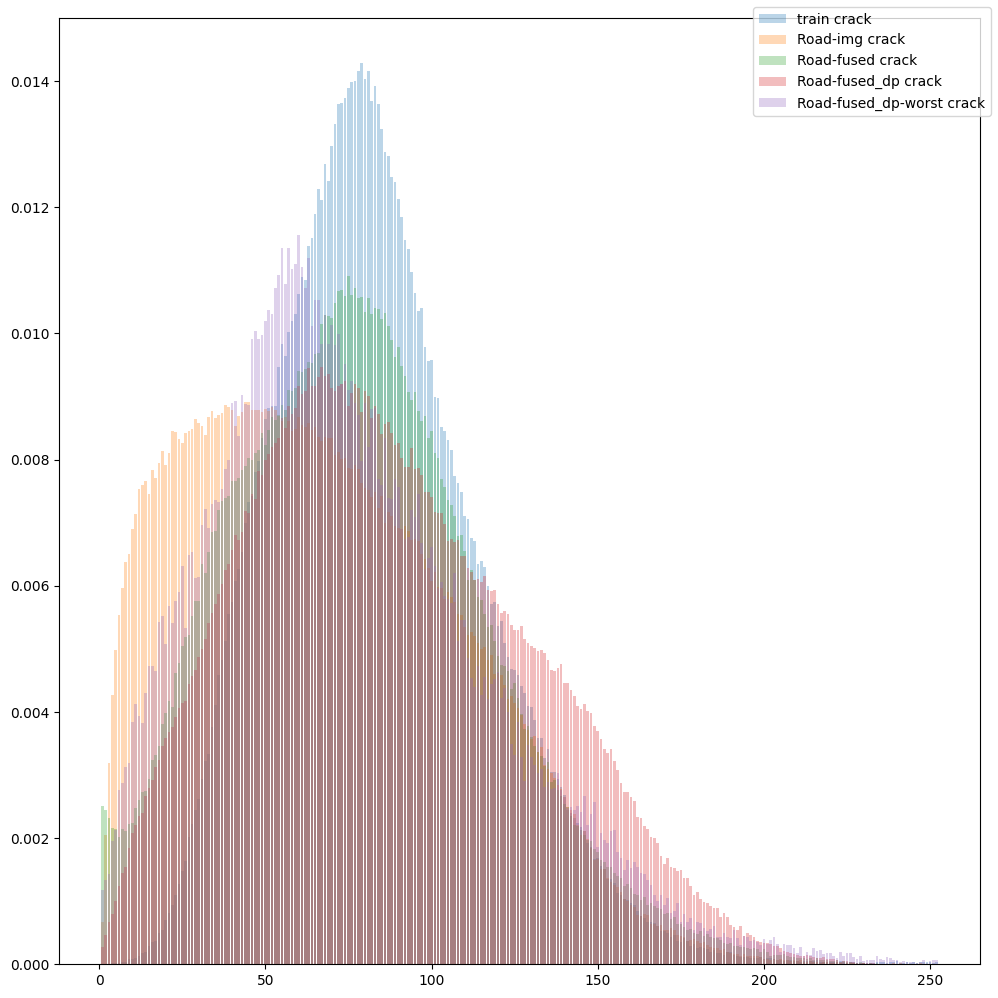

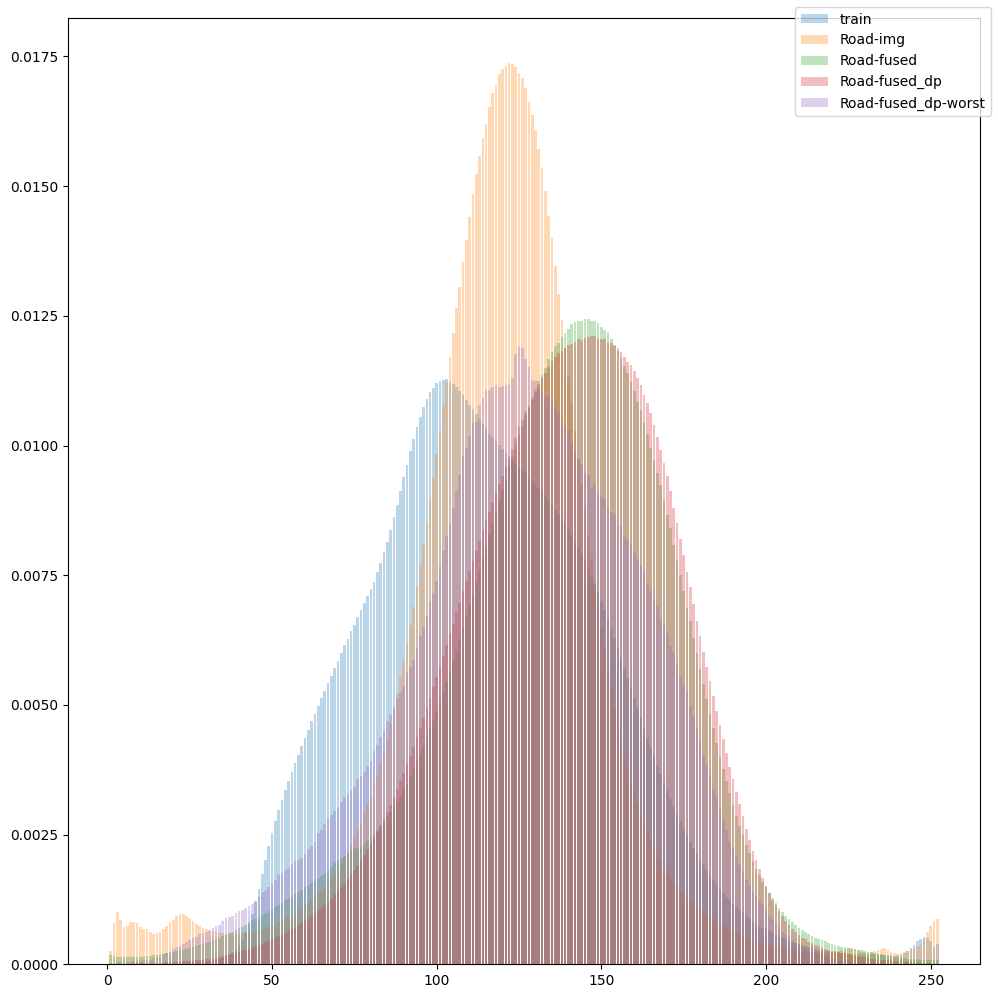

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))
for p, label in zip(pix_crack, ['train', 'Road-img', 'Road-fused', 'Road-fused_dp', "Road-fused_dp-worst"]):
    ax.bar(x, p.numpy(), alpha=0.3, label=label+" crack")

fig.tight_layout()
fig.legend(loc="upper right")

fig, ax = plt.subplots(figsize=(10, 10))
for p, label in zip(pix_bg, ['train', 'Road-img', 'Road-fused', 'Road-fused_dp', "Road-fused_dp-worst"]):
    ax.bar(x, p.numpy(), alpha=0.3, label=label)

fig.tight_layout()
fig.legend(loc="upper right")
plt.show()

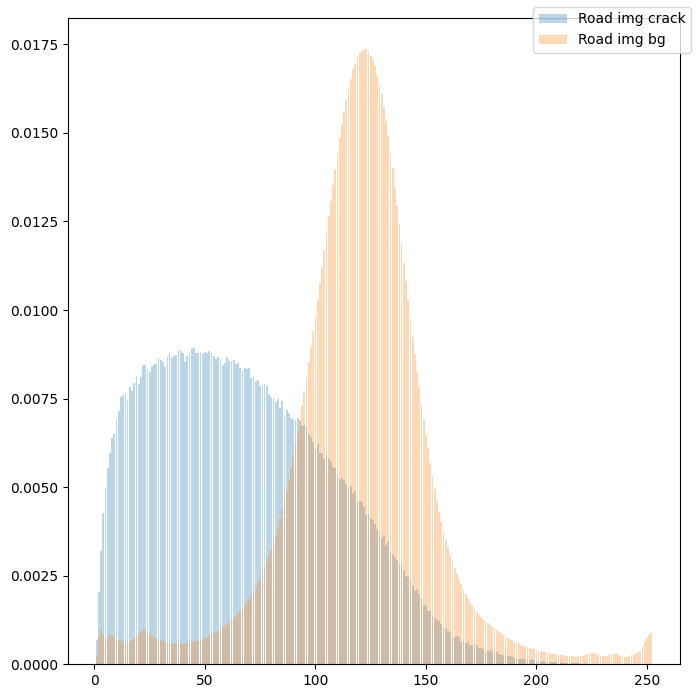

In [77]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.bar(x, pix_crack[1].numpy(), alpha=0.3, label= "Road img crack")
ax.bar(x, pix_bg[1].numpy(), alpha=0.3, label="Road img bg")

fig.tight_layout()
fig.legend(loc="upper right")

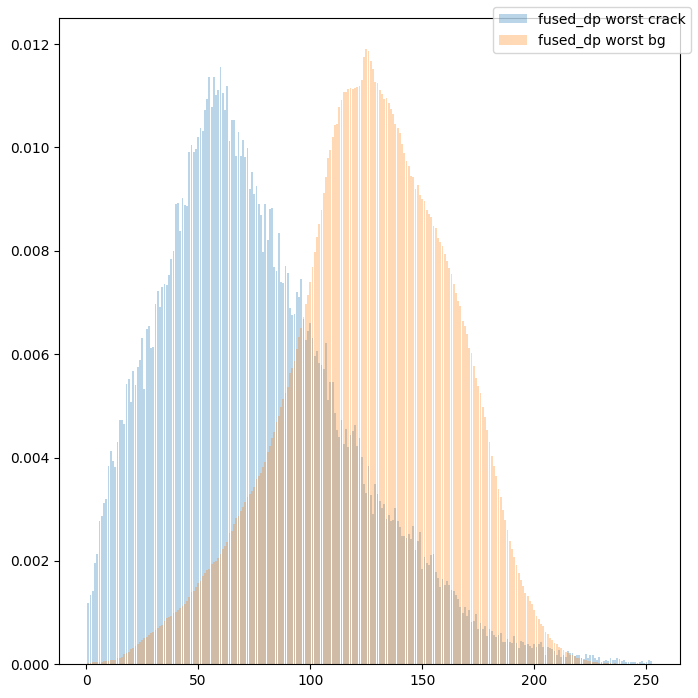

In [82]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.bar(x, pix_crack[-1].numpy(), alpha=0.3, label= "fused_dp worst crack")
ax.bar(x, pix_bg[-1].numpy(), alpha=0.3, label="fused_dp worst bg")

fig.tight_layout()
fig.legend(loc="upper right")

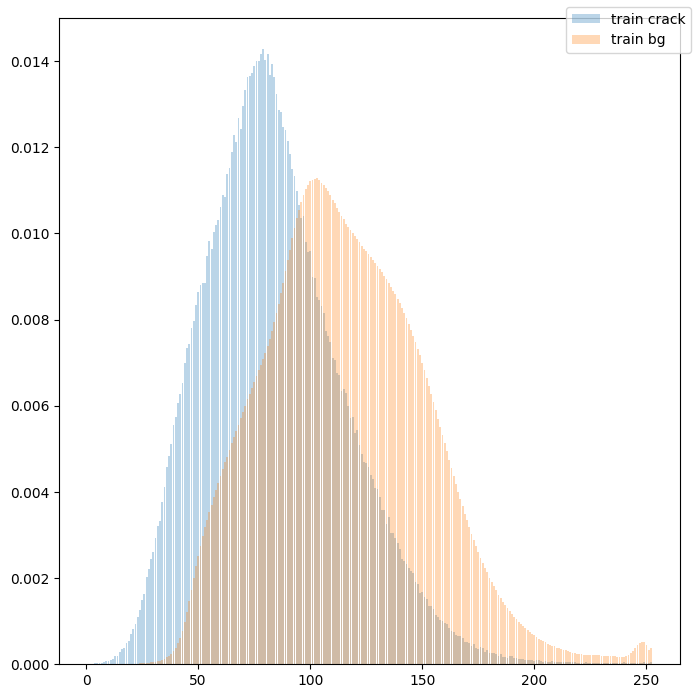

In [73]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.bar(x, pix_crack[0].numpy(), alpha=0.3, label= "train crack")
ax.bar(x, pix_bg[0].numpy(), alpha=0.3, label="train bg")

fig.tight_layout()
fig.legend(loc="upper right")